<a href="https://colab.research.google.com/github/garciamilord/EmaTrading/blob/main/EMATrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

--2021-10-23 15:30:29--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-10-23 15:30:30--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-10-23 15:30:30--  http://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving nchc.dl.sourceforge.n

In [8]:
pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 6.3 MB 6.7 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=2f9021a0459946c0db4125cb21964ec796113918427ec99621f8546c9ec11b53
  Stored in directory: /tmp/pip-ephem-wheel-cache-lp6jogou/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [10]:
pip install bt

     |████████████████████████████████| 2.7 MB 3.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for bt: filename=bt-0.2.9-cp37-cp37m-linux_x86_64.whl size=765328 sha256=60e41d21ec4f32edb8c775a0d61bdecb010f20aae4de6f5e7a4a50e86dc24859
  Stored in directory: /root/.cache/pip/wheels/c5/1a/3f/b56e6064b766c107f25e200969161c09ca6868cbfe0eaa31e4
Successfully built bt


In [12]:

import talib
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import date
import bt 

ticker = "aapl"
today = date.today().strftime("%Y-%m-%d")
stock_data = yf.download(ticker, start="2020-1-1", end=today)

[*********************100%***********************]  1 of 1 completed


In [13]:

EMA_short = talib.EMA(stock_data['Close'], timeperiod=12).to_frame()
EMA_short = EMA_short.rename(columns={0: 'Close'})
EMA_long = talib.EMA(stock_data['Close'], timeperiod=50).to_frame()
EMA_long = EMA_long.rename(columns={0: 'Close'})

signal = EMA_long.copy()
signal[EMA_long.isnull()] = 0
signal[EMA_short > EMA_long] = 1
signal[EMA_short < EMA_long] = -1

In [14]:
transition = signal[signal['Close'].diff()!=0]
buy_signal = transition[transition['Close'] == 1]
sell_signal = transition[transition['Close'] == -1]

long_index = buy_signal.index
buy_position = stock_data[stock_data.index.isin(long_index)]
short_index = sell_signal.index
sell_position = stock_data[stock_data.index.isin(short_index)]

fig = go.Figure()
fig.add_trace(
        go.Candlestick(x=stock_data.index,
                open=stock_data['Open'],
                high=stock_data['High'],
                low=stock_data['Low'],
                close=stock_data['Close'],
                name="Stock Prices"
                      )            
)

fig.add_trace(
        go.Scatter(
            x=stock_data.index,
            y=EMA_long['Close'],
            name="EMA 50"
        )
)

fig.add_trace(
        go.Scatter(
            x=stock_data.index,
            y=EMA_short['Close'],
            name = "EMA 12"
        )
)

fig.add_trace(
        go.Scatter(
            x=buy_position.index,
            y=buy_position['Close'], 
            name="Buy Signal",
            marker=dict(color="#511CFB", size=15),
            mode="markers",
            marker_symbol="triangle-up"
        )
)

fig.add_trace(
        go.Scatter(
            x=sell_position.index,
            y=sell_position['Close'], 
            name="Sell Signal",
            marker=dict(color="#750086", size=15),
            mode="markers",
            marker_symbol="triangle-down"
        )
)

fig.update_layout(
    xaxis_rangeslider_visible=False,
    title="Daily Close (" + ticker + ") Prices",
    xaxis_title="Date",
    yaxis_title="Price (USD)"
)
fig.show()

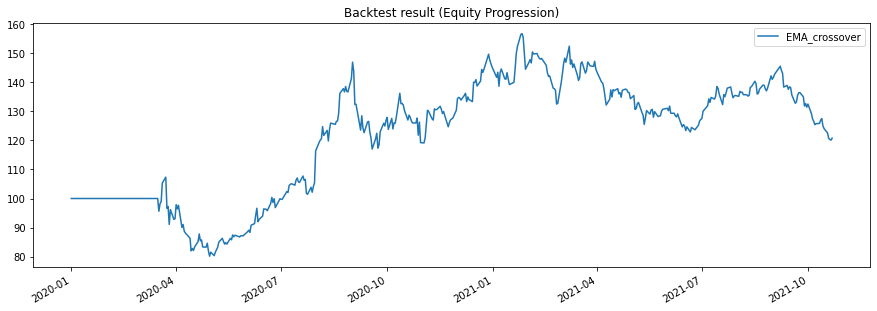

In [15]:
%matplotlib inline

bt_strategy = bt.Strategy('EMA_crossover',
                            [   bt.algos.RunWeekly(),
                                bt.algos.WeighTarget(signal),
                                bt.algos.Rebalance()
                            ]
                         )

bt_backtest = bt.Backtest(bt_strategy, stock_data['Close'].to_frame())
bt_result = bt.run(bt_backtest)
bt_result.plot(title='Backtest result (Equity Progression)')
plt.show()

Text(0.5, 0.98, 'weekly Return Histogram Matrix')

<Figure size 432x288 with 0 Axes>

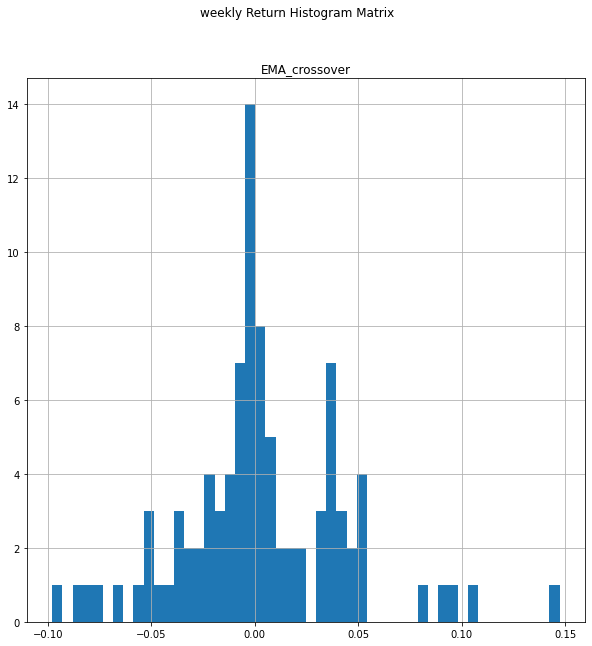

In [16]:
bt_result.plot_histograms(bins=50, freq = 'w')


In [17]:
bt_result.display()

Stat                 EMA_crossover
-------------------  ---------------
Start                2020-01-01
End                  2021-10-22
Risk-free rate       0.00%

Total Return         20.80%
Daily Sharpe         0.49
Daily Sortino        0.77
CAGR                 11.02%
Max Drawdown         -25.39%
Calmar Ratio         0.43

MTD                  -8.13%
3m                   -11.45%
6m                   -10.45%
YTD                  -16.90%
1Y                   -4.74%
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  11.02%

Daily Sharpe         0.49
Daily Sortino        0.77
Daily Mean (ann.)    15.60%
Daily Vol (ann.)     32.15%
Daily Skew           -0.23
Daily Kurt           3.99
Best Day             10.47%
Worst Day            -10.03%

Monthly Sharpe       0.47
Monthly Sortino      1.09
Monthly Mean (ann.)  16.29%
Monthly Vol (ann.)   34.36%
Monthly Skew         0.42
Monthly Kurt         -0.90
Best Month           21.44%
Worst Month          -1

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
